## Backprojetion from triangulation

In [48]:
# import necessary modules
import matplotlib.pyplot as plt
import numpy as np

import multicam_calibration as mcc
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import plotly.express as px
import pickle
import re
import cv2
from threed_utils.io import movement_ds_from_anipose_triangulation_df, read_calibration_toml
from tqdm import tqdm
import xarray as xr
import plotly.graph_objects as go

### get triangulation from predictions: mcc, anipose

In [4]:
# get data from one session:
from pathlib import Path
dir_path = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240724\100455\multicam_video_2024-07-24T10_20_07_cropped_20241209165236")
calibration_path = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240724\calibration\multicam_video_2024-07-24T14_13_45_cropped_20241209165236")

### Get calibration matrices

to do for debugging:
- run the whole pipeline on the checkboard data
- triangulation checkboard
- backprojection checkboard
- plot checkboard on frames

from that you can understand the possible issue with the current pipeline


### checkboard triangulation and backprojection

In [4]:
data_dir = Path('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration')

In [303]:
calibration_paths = sorted(data_dir.glob("mc_calibration_output_*"))
last_calibration_path = calibration_paths[-1]

all_calib_uvs = np.load(last_calibration_path / "all_calib_uvs.npy")
calib_toml_path = last_calibration_path / "calibration_from_mc.toml"
cam_names, img_sizes, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)

In [128]:
checkboard = data_dir / 'checkboard_triangulaiton.h5'
checkboard_ds = xr.open_dataset(checkboard)


In [137]:
checkboard_ds.info

<bound method Dataset.info of <xarray.Dataset> Size: 4MB
Dimensions:      (time: 856, keypoints: 35, view: 5, individuals: 1, space: 2)
Coordinates:
  * time         (time) int32 3kB 145 146 147 148 149 ... 996 997 998 999 1000
  * keypoints    (keypoints) object 280B '0' '1' '2' '3' ... '31' '32' '33' '34'
  * view         (view) object 40B 'mirror-top' 'mirror-bottom' ... 'central'
  * space        (space) object 16B 'x' 'y'
  * individuals  (individuals) object 8B 'checkerboard'
Data variables:
    confidence   (view, time, keypoints, individuals) float64 1MB ...
    position     (view, time, space, keypoints, individuals) float64 2MB nan ...
Attributes:
    fps:              fps
    time_unit:        frames
    source_software:  opencv
    source_file:      mcc
    ds_type:          poses>

In [140]:
check_array = checkboard_ds.position.values.squeeze().shape

In [ ]:
all_triang = []
for i in tqdm(range(checkboard_ds.time.size)):
    all_triang.append(mcc.triangulate(checkboard_ds.position.isel(time=i).values, extrinsics, intrinsics))



In [143]:
checkboard_ds.position.isel(time=0).values.shape

(5, 2, 35, 1)

In [144]:
checkboard_ds.position.values.shape
# change the dimension to match (semantically)
all_triang = []

for i in tqdm(range(checkboard_ds.time.size)):
    all_triang.append(mcc.triangulate(checkboard_ds.position.isel(time=i).values.squeeze().transpose(0, 2, 1), extrinsics, intrinsics))
    

100%|██████████| 856/856 [00:00<00:00, 1484.80it/s]


In [145]:
check_triang_arr = np.array(all_triang)
check_triang_arr.shape


(856, 35, 3)

In [147]:
def plot_best_frame(points_array):
    """
    Find and plot the frame with the most non-NaN values.
    
    Args:
        points_array: numpy array of shape (n_frames, n_keypoints, 3)
    """
    # Count non-NaN values for each frame
    valid_points_per_frame = np.sum(~np.isnan(points_array).any(axis=2), axis=1)
    
    # Find the frame with maximum valid points
    best_frame_idx = np.argmax(valid_points_per_frame)
    best_frame = points_array[best_frame_idx]
    
    # Remove any remaining NaN points
    valid_mask = ~np.isnan(best_frame).any(axis=1)
    valid_points = best_frame[valid_mask]
    
    # Create 3D plot
    fig = go.Figure()
    
    # Add points
    fig.add_trace(go.Scatter3d(
        x=valid_points[:, 0],
        y=valid_points[:, 1],
        z=valid_points[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=np.arange(len(valid_points)),  # Color points by index
            colorscale='Viridis',
        )
    ))
    
    fig.update_layout(
        title=f'Frame {best_frame_idx} with {len(valid_points)} valid points',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )
    
    fig.show()
    
    return best_frame_idx, valid_points

# Using your triangulation array:
best_frame_idx, valid_points = plot_best_frame(check_triang_arr)

Now we get the backprojections and plot them over the original image:

In [178]:
def backproject_triangulated_points(array, extrinsics, intrinsics, frame_n, cam_names):
    """
    Back-project 3D triangulated points to 2D camera coordinates for a specific frame.
    
    Args:
        xarray_ds (xarray.Dataset): Dataset containing triangulated points with dimensions:
            (time: 1001, keypoints: 13, individuals: 1, space: 3)
        extrinsics (list): List of extrinsic matrices for each camera
        intrinsics (list): List of intrinsic matrices for each camera
        frame_n (int): Frame number to process
        
    Returns:
        dict: Dictionary of back-projected points for each camera
    """


    camera_matrices = [i[0] for i in intrinsics]
    dist_coef = [i[1] for i in intrinsics]
    # Extract 3D points for the specified frame
    # Shape will be (space, keypoints, individuals)

    # do semantic ordering of columns

     # Now shape is (keypoints, space)
    
    # Initialize dictionary to store back-projecoints for each camera
    arr = array[frame_n, :, :]
    back_projected = mcc.project_points(arr, extrinsics, camera_matrices)

    back_projected_points = {camera: [points, arena] for camera, points, arena in zip(cam_names, back_projected)}
    
    
    return back_projected_points

In [164]:
camera_matrices = [i[0] for i in intrinsics]
back_projected = mcc.project_points(arr, extrinsics, camera_matrices)

(35, 3)

In [171]:
check_triang_arr[310: 312, :, :].transpose(1, 2, 0).shape

(35, 3, 2)

In [187]:
n_cameras = len(checkboard_ds.view.values.tolist())
n_frames = check_triang_arr.shape[0]
N = check_triang_arr.shape[1]

reprojections = np.zeros((n_cameras, n_frames, N, 2))
for cam in tqdm(range(len(checkboard_ds.view.values.tolist()))):
    reprojections[cam] = mcc.project_points(
        check_triang_arr, extrinsics[cam], intrinsics[cam][0]
    )

100%|██████████| 5/5 [00:00<00:00, 437.55it/s]


In [189]:
import re
backprojections_frames = {}
video_dir = Path('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration')
video_paths = sorted(video_dir.glob("*.mp4"))

# Regex to extract camera name from video file names
camera_name_regex = re.compile(r".*_(\w+(?:-\w+)?)\.avi\.mp4$")

In [190]:
video_camera_map = {}
for video_path in video_paths:
    match = camera_name_regex.match(video_path.name)
    if match:
        camera_name = match.group(1)
        video_camera_map[camera_name] = video_path
    else:
        raise ValueError(f"Could not extract camera name from: {video_path.name}")

In [193]:
reprojections[0,0,  ...].shape

(35, 2)

In [214]:
cam_points = {}
for i, cam in enumerate(checkboard_ds.view.values.tolist()):
    cam_points[cam] = (reprojections[i, 310,...], read_nth_frame(video_camera_map[cam], 310+145))

In [215]:
def plot_frames_with_points_t(camera_data):
    """
    Plots frames with tracked points in subplots, using camera names as titles.

    Args:
        camera_data (dict): A dictionary where keys are camera names and values are tuples:
                            (frame (numpy array), tracked points (list or numpy array)).
    """
    # Determine the number of subplots needed
    n_cameras = len(camera_data.keys())
    n_cols = 3  # Number of columns in the grid
    n_rows = -(-n_cameras // n_cols)  # Ceiling division to get rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten axes for easy iteration
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    # Loop over cameras and plot data
    for idx, (camera_name, (points, frame)) in enumerate(camera_data.items()):
        ax = axes[idx]
        ax.imshow(frame)  # Display the frame
        points = np.array(points)  # Ensure points are in array form
        if len(points) > 0:
            ax.scatter(points[:, 0], points[:, 1], color='red', s=10)
            ax.scatter(points[:, 0], points[:, 1], color='blue', s=10)  # Plot points
        ax.set_title(camera_name)
        ax.axis('off')  # Turn off axis for a cleaner look

    # Hide unused subplots
    for i in range(len(camera_data), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

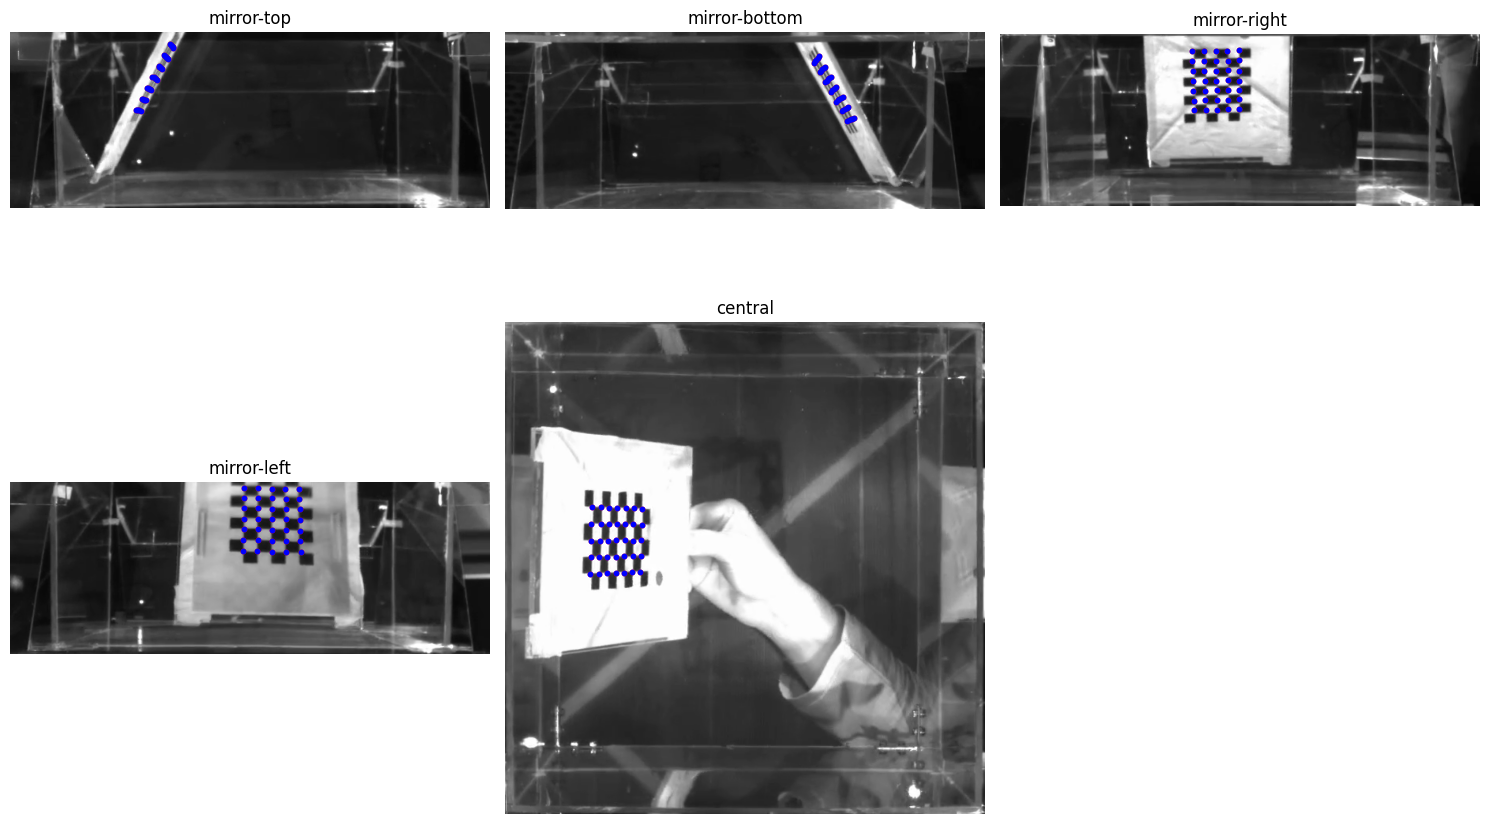

In [216]:
plot_frames_with_points_t(cam_points)

In [7]:
slp_dir = Path('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/video_test')

triangulation_path = slp_dir / 'anipose_triangulated_ds.h5'
mcc_path = slp_dir / 'mcc_triangulated_ds.h5'
anipose_ds = xr.open_dataset(triangulation_path)
mcc_ds = xr.open_dataset(mcc_path)


In [9]:
arena_path = '/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/3d-setup/tests/assets/arena_tracked_points.pkl'
with open(arena_path, 'rb') as f:
    arena_points = pickle.load(f)

## Utility Functions 

How to get store indices from original video to xarray?

In [244]:
def triangulate_all_keypoints(
    calib_uvs, extrinsics, intrinsics, progress_bar=True
):
    all_triang = []
    calib_uvs = calib_uvs.reshape((5, 1, 8, 2))
    progbar = tqdm if progress_bar else lambda x: x
    for i in progbar(range(calib_uvs.shape[2])):
        all_triang.append(
            mcc.triangulate(calib_uvs[:, :, i, :], extrinsics, intrinsics)
        )

    return np.array(all_triang)

In [243]:

with open(arena_path, 'rb') as f:
    points = pickle.load(f)
arena_points = points['points']['arena_coordinates'].squeeze()
arena_points.shape.



(5, 8, 2)

function that backporject a dataset given the matrices 

In [366]:
mcc_ds.position.values[0, ...].squeeze().shape

(3, 13)

In [367]:
def backproject_triangulated_points(xarray_ds, extrinsics, intrinsics, frame_n, cam_names, arena_3d):
    """
    Back-project 3D triangulated points to 2D camera coordinates for a specific frame.
    
    Args:
        xarray_ds (xarray.Dataset): Dataset containing triangulated points with dimensions:
            (time: 1001, keypoints: 13, individuals: 1, space: 3)
        extrinsics (list): List of extrinsic matrices for each camera
        intrinsics (list): List of intrinsic matrices for each camera
        frame_n (int): Frame number to process
        
    Returns:
        dict: Dictionary of back-projected points for each camera
    """
    video_paths = sorted(slp_dir.glob("*.mp4"))

    camera_matrices = [i[0] for i in intrinsics]
    dist_coef = [i[1] for i in intrinsics]
    # Extract 3D points for the specified frame
    # Shape will be (space, keypoints, individuals)
    frame_points = xarray_ds.position.values[frame_n, ...].squeeze().transpose(1, 0)
    # do semantic ordering of columns

     # Now shape is (keypoints, space)
    
    # Initialize dictionary to store back-projected points for each camera
    
    n_cameras = len(cam_names)
    n_frames = mcc_ds.time.size
    N = mcc_ds.keypoints.size

    reprojections = np.zeros((n_cameras, n_frames, N, 2))
    for cam in tqdm(range(len(checkboard_ds.view.values.tolist()))):
        reprojections[cam] = mcc.project_points(
            frame_points, extrinsics[cam], intrinsics[cam][0]
    )

    arena2d = {}
    for cam in tqdm(range(len(checkboard_ds.view.values.tolist()))):
        arena2d[cam] = mcc.project_points(
            arena_3d, extrinsics[cam], intrinsics[cam][0]
    )
    return arena2d, reprojections

In [73]:
def read_nth_frame(input_file, n):
    """
    Reads the nth frame from the input video file.

    Args:
        input_file (str or Path): Path to the video file.
        n (int): Frame number to read (0-indexed).

    Returns:
        np.ndarray: The nth frame as an image array.

    Raises:
        ValueError: If the frame cannot be read or the frame number is out of bounds.
    """
    # Open the video file
    cap = cv2.VideoCapture(str(input_file))
    
    # Check if the video was successfully opened
    if not cap.isOpened():
        raise ValueError(f"Failed to open the video file: {input_file}")
    
    # Set the frame position
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if n < 0 or n >= total_frames:
        cap.release()
        raise ValueError(f"Frame number {n} is out of bounds for video with {total_frames} frames.")
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)
    
    # Read the frame
    ret, frame = cap.read()
    if not ret:
        cap.release()
        raise ValueError(f"Failed to read frame {n} from the video.")
    
    # Release the video capture object
    cap.release()
    
    return frame

In [273]:
def get_frames_camera(cam_names, n_frame, video_dir):
    """
    Associates video frames with their corresponding camera keys from backprojections.

    Args:
        cam_names (list): List of camera names in the desired order
        n_frame (int): Frame number to extract.
        video_dir (Path): Directory containing the video files.

    Returns:
        dict: Dictionary with keys as camera names (in original order) and values as video frames
    """
    video_paths = sorted(video_dir.glob("*.mp4"))

    # Regex to extract camera name from video file names
    camera_name_regex = re.compile(r".*_(\w+(?:-\w+)?)\.avi\.mp4$")

    # Create a map of camera name to video path
    video_camera_map = {}
    for video_path in video_paths:
        match = camera_name_regex.match(video_path.name)
        if match:
            camera_name = match.group(1)
            video_camera_map[camera_name] = video_path
        else:
            raise ValueError(f"Could not extract camera name from: {video_path.name}")

    # Create dictionary maintaining cam_names order
    camera_frames = {}
    for name in cam_names:
        if name not in video_camera_map:
            raise ValueError(f"Camera {name} not found in video directory")
        camera_frames[name] = read_nth_frame(video_camera_map[name], n_frame)

    return camera_frames


In [352]:


def plot_frames_with_points(cam_names, back_projected, video_camera_map, arena_2d, arena_points):
    """
    Plots frames with tracked points in subplots, using camera names as titles.

    Args:
        camera_data (dict): A dictionary where keys are camera names and values are tuples:
                            (frame (numpy array), tracked points (list or numpy array)).
    """
    # Determine the number of subplots needed
    n_cameras = len(cam_names)
    n_cols = 3  # Number of columns in the grid
    n_rows = -(-n_cameras // n_cols)  # Ceiling division to get rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    arena_points = arena_points.squeeze()

    # Flatten axes for easy iteration
    axes = axes.flatten() if n_rows > 1 else [axes]
    arena_points_p = [arena_view.squeeze() for arena_view in arena_2d.values()]
    # Loop over cameras and plot data
    for idx in range(len(cam_names)):
        ax = axes[idx]
        ax.imshow(video_camera_map[cam_names[idx]])  # Display the frame
        points = np.array(back_projected[idx])  # Ensure points are in array form
        if len(points) > 0:
            ax.scatter(points[n_frames][:, 0], points[n_frames][:, 1], color='red', s=10)
            ax.scatter(arena_points_p[idx][:, 0], arena_points_p[idx][:, 1], color='blue', s=10)
            # ax.scatter(arena_2d[idx, :, 1], arena_2d[idx, :, 0], color='blue', s=10)  # Plot points
        ax.set_title(cam_names[idx])
        ax.axis('off')  # Turn off axis for a cleaner look

    # Hide unused subplots
    for i in range(len(cam_names), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



In [104]:
def plot3d_frame(frame_points3d, arena_3d):
    frame_points3d = frame_points3d.squeeze()
    arena_3d = arena_3d.squeeze()
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=frame_points3d[:, 0], y=frame_points3d[:, 1], z=frame_points3d[:, 2], mode='markers', marker=dict(size=5, color='red')))
    #add arena points 
    fig.add_trace(go.Scatter3d(x=arena_3d[:, 0], y=arena_3d[:, 1], z=arena_3d[:, 2], mode='markers', marker=dict(size=5, color='blue')))
    fig.show()


## Final Function

In [356]:
# function that combines the previous functions into a single one by calling them:

def backprojections_plots(ds, n_frame, video_dir, calibration_dir, arena_path):


    # load the calibration matrices:
    calibration_path = Path(calibration_dir)
    calibration_paths = sorted(data_dir.glob("mc_calibration_output_*"))
    last_calibration_path = calibration_paths[-1]

    all_calib_uvs = np.load(last_calibration_path / "all_calib_uvs.npy")
    calib_toml_path = last_calibration_path / "calibration_from_mc.toml"
    print(calib_toml_path)
    cam_names, img_sizes, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)
    # with open(arena_path, 'rb') as f:
    #     points = pickle.load(f)
    # arena_points = points['points']['arena_coordinates'].squeeze()
    # new_order = [4, 2, 1, 3, 0]
    # arena_points_n = arena_points[new_order, ...]

    import json

    cropping_path = '/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/uncropped_cal/multicam_video_2024-07-22T10_19_22_20241209-164946.json'
    with open(cropping_path, 'r') as f:
        cropping_dict = json.load(f)
    old_arena = cropping_dict[-1]['points_coordinate']
    arena_points_new = np.zeros_like(arena_points)



    for i, cam in enumerate(cam_names):
        arena_points_new[i, ...] = old_arena[cam]




    arena_3d = triangulate_all_keypoints(arena_points_new[..., [1, 0]], extrinsics, intrinsics)

    arena_2d, back_projected = backproject_triangulated_points(ds, extrinsics, intrinsics, n_frame, cam_names, arena_3d)
    frame_points3d = ds.isel(time=n_frame).position.values.squeeze().transpose(1, 0)
    plot3d_frame(frame_points3d, arena_3d)
    print(back_projected.shape)


    video_camera_map = get_frames_camera(cam_names, n_frame, video_dir)


    plot_frames_with_points(cam_names, back_projected, video_camera_map, arena_2d, arena_points_new)


/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration/mc_calibration_output_20241210-164414/calibration_from_mc.toml


100%|██████████| 5/5 [00:00<00:00, 17549.39it/s]


(5, 1001, 13, 2)


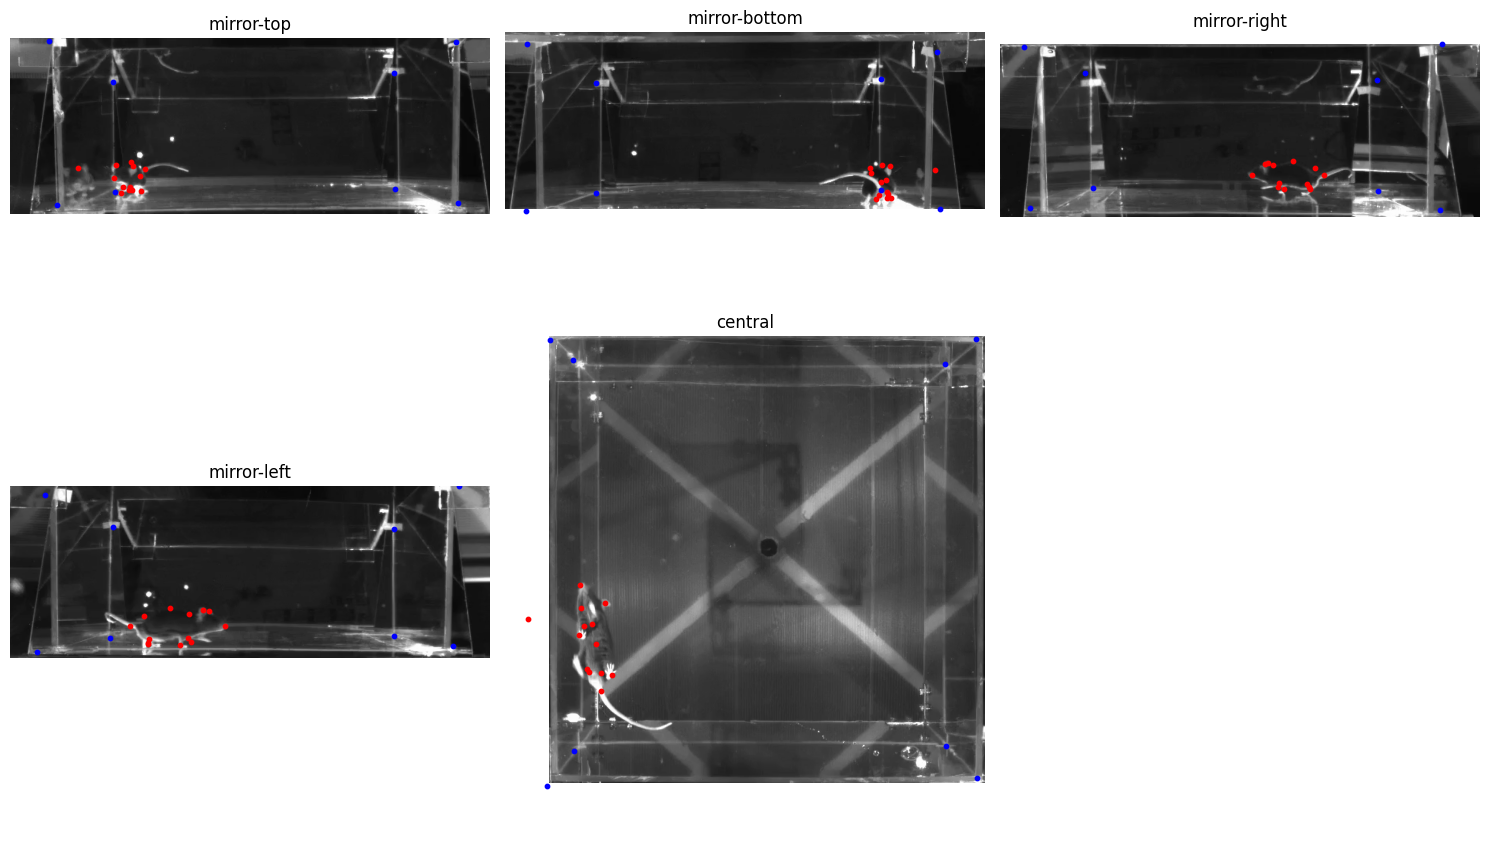

In [368]:
calibration_path = '/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration'
backprojections_plots(mcc_ds, 0, slp_dir, calibration_path, arena_path)

## Further Debugging:

- enforce camera order when getting points arena
- enforce camera order during triangulation

- Backproject arena from triangulaiton
- re run triangulaiton of points with order
- back-project points from triangulation
- write general script for that for xarrays

In [324]:
cam_names

['mirror-top', 'mirror-bottom', 'mirror-right', 'mirror-left', 'central']

In [2]:
#load json of arean_points
import json

cropping_path = '/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/uncropped_cal/multicam_video_2024-07-22T10_19_22_20241209-164946.json'
with open(cropping_path, 'r') as f:
    cropping_dict = json.load(f)



In [3]:
old_arena = cropping_dict[-1]['points_coordinate']

In [9]:
import numpy as np
arr_arena = []
for key, value in old_arena.items():
    arr_arena.append(value)

arr_arena = np.array(arr_arena)
arr_arena.shape


(5, 8, 2)

## Testing Preparation

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import multicam_calibration.geometry as mcc_geom
import numpy as np
import pandas as pd
import xarray as xr
from movement.io.load_poses import from_numpy
from threed_utils.io import movement_ds_from_anipose_triangulation_df, read_calibration_toml

from threed_utils.anipose.triangulate import CameraGroup, triangulate_core



In [11]:

data_dir = Path("/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration")
# data_dir = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240726\Calibration\multicam_video_2024-07-26T11_40_54_cropped_20240726164916")
# Read checkerboard detections as movement dataset

# Load last available calibration among mc_calibrarion_output_*
calibration_paths = sorted(data_dir.glob("mc_calibration_output_*"))
last_calibration_path = calibration_paths[-1]

all_calib_uvs = np.load(last_calibration_path / "all_calib_uvs.npy")
calib_toml_path = last_calibration_path / "calibration_from_mc.toml"
print(calib_toml_path)
cam_names, img_sizes, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)

print(all_calib_uvs.shape)



/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration/mc_calibration_output_20241210-164414/calibration_from_mc.toml
(5, 14656, 35, 2)


In [17]:
# we want to load the arena data in the same why that we load the checkerboard data

cropping_path = '/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/uncropped_cal/multicam_video_2024-07-22T10_19_22_20241209-164946.json'
with open(cropping_path, 'r') as f:
    cropping_dict = json.load(f)

old_arena = cropping_dict[-1]['points_coordinate']


arena_points_new = np.zeros((5, 8, 2))
for i, cam in enumerate(cam_names):
    arena_points_new[i, ...] = old_arena[cam]
arena_points_new = arena_points_new.reshape((5, 1, 8, 2
                                             ))

In [50]:
all_calib_uvs = arena_points_new[..., [1, 0]]

In [51]:
# Temporary patch for loading checkerboard data as dataset:
views_dss = []
for n_view, view in enumerate(cam_names):
    # position_array = np.moveaxis(all_calib_uvs[n_view], 0, -1)  # Move views to last axis
    position_array = all_calib_uvs[n_view]
    position_array = position_array[:, np.newaxis, :, :]
     # to match position array exp
    print(f"Final position_array shape: {position_array.shape}")  # Add individuals axis
    confidence_array = np.ones(position_array.shape[:-1]).transpose(0, 2, 1)

    keypoint_names = [str(i) for i in range(position_array.shape[2])]
    position_array = position_array.transpose(0, 3, 2, 1)
    individual_names = ["checkerboard"]
    source_software = "opencv"

    views_dss.append(from_numpy(position_array=position_array, 
                                confidence_array=confidence_array,
                                individual_names=individual_names,
                                keypoint_names=keypoint_names,
                                source_software=source_software,
                                ))
    
new_coord_views = xr.DataArray(cam_names, dims="view")

views_ds = xr.concat(views_dss, dim=new_coord_views)

# time_slice = slice(145, 1000)
# views_ds = views_ds.sel(time=time_slice, drop=True)

views_ds.attrs['fps'] = 'fps'

views_ds.attrs['source_file'] = 'mcc'


# views_ds.to_netcdf(data_dir / "checkboard_triangulaiton.h5")

Final position_array shape: (1, 1, 8, 2)
Final position_array shape: (1, 1, 8, 2)
Final position_array shape: (1, 1, 8, 2)
Final position_array shape: (1, 1, 8, 2)
Final position_array shape: (1, 1, 8, 2)


In [52]:
def mcc_triangulate_ds(
    xarray_dataset, calib_toml_path, progress_bar=True
):
    cam_names, _, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)

    positions = xarray_dataset.position
    confidence = xarray_dataset.confidence  # TODO implement confidence propagation

    # use cam_names to sort the view axis, after having checked that the views are the same:
    print(xarray_dataset.coords["view"].values, cam_names)
    assert set(xarray_dataset.coords["view"].values) == set(cam_names), "Views do not match: " + str(list(positions.coords["view"])) + " vs " + str(cam_names)
    positions = positions.sel(view=cam_names)
    print(positions.coords["view"].values)
    
    # get first individual, regarless of its name:
    positions = positions.sel(individuals=positions.coords["individuals"][0], drop=True)

    # enforce order:
    positions = positions.transpose("view", "time", "keypoints", "space").values
    all_triang = []
    for i in tqdm(range(len(xarray_dataset.coords["keypoints"])), "Triangulating keypoints: ", 
                  disable=not progress_bar):
        triang = mcc_geom.triangulate(positions[:, :, i, :], extrinsics, intrinsics)
        all_triang.append(triang)

    threed_coords = np.array(all_triang)  # shape n_keypoints, n_frames, 3
    # reshape to n_frames, 1, n_keypoints, 3
    threed_coords = threed_coords.transpose(1, 0, 2)[:, np.newaxis, :, :]
    # TODO propagate confidence smartly
    confidence_array = np.ones(threed_coords.shape[:-1])
    #change again shape to match anipose:
    print(threed_coords.shape, confidence_array.shape)
    threed_coords = threed_coords.transpose(0, 3, 2, 1)
    confidence_array = confidence_array.transpose(0, 2, 1)
    

    return from_numpy(position_array=threed_coords,
               confidence_array=confidence_array,
               individual_names=xarray_dataset.coords["individuals"].values,
               keypoint_names=xarray_dataset.coords["keypoints"].values,
               source_software=xarray_dataset.attrs["source_software"] + "_triangulated",
               )

view_ds_triangulated = mcc_triangulate_ds(views_ds, calib_toml_path)

['mirror-top' 'mirror-bottom' 'mirror-right' 'mirror-left' 'central'] ['mirror-top', 'mirror-bottom', 'mirror-right', 'mirror-left', 'central']
['mirror-top' 'mirror-bottom' 'mirror-right' 'mirror-left' 'central']


Triangulating keypoints: 100%|██████████| 8/8 [00:00<00:00, 1776.59it/s]

(1, 1, 8, 3) (1, 1, 8)


In [40]:
view_ds_triangulated.position.values.shape

(1, 3, 8, 1)

In [53]:
def plot3d_frame_(frame_points3d):
    frame_points3d = frame_points3d.squeeze()
    # arena_3d = arena_3d.squeeze()
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=frame_points3d[:, 0], y=frame_points3d[:, 1], z=frame_points3d[:, 2], mode='markers', marker=dict(size=5, color='red')))
    #add arena points 
    # fig.add_trace(go.Scatter3d(x=arena_3d[:, 0], y=arena_3d[:, 1], z=arena_3d[:, 2], mode='markers', marker=dict(size=5, color='blue')))
    fig.show()


In [54]:
view_ds_triangulated.position.values.shape

(1, 3, 8, 1)

In [55]:
plot3d_frame_(view_ds_triangulated.position.values.squeeze().transpose(1, 0))

In [56]:
test_data_dir = Path("../tests/assets")

In [61]:
from shutil import copy2

In [64]:
views_ds.attrs['fps'] = 'fps'

views_ds.attrs['source_file'] = 'mcc'

view_ds_triangulated.attrs['fps'] = 'fps'

view_ds_triangulated.attrs['source_file'] = 'mcc_triangulated'

views_ds.to_netcdf(test_data_dir / "arena_views.h5")
view_ds_triangulated.to_netcdf(test_data_dir / "arena_views_triangulated.h5")
copy2(calib_toml_path, test_data_dir / "calibration.toml")

PosixPath('../tests/assets/calibration.toml')

In [83]:
from threed_utils.triangulation_ds import mcc_triangulate_ds

In [84]:
def test_arena_triangulation(
    arena_views_ds,
    calibration_toml,
    expected_triangulated_ds
):
    """Test that triangulation produces expected 3D coordinates."""
    
    # Run triangulation
    actual_ds = mcc_triangulate_ds(arena_views_ds, calibration_toml)
    
    # Compare position values
    np.testing.assert_allclose(
        actual_ds.position.values,
        expected_triangulated_ds.position.values,
        rtol=1e-5,
        atol=1e-5,
        err_msg="Triangulated positions don't match expected values"
    )
    
    # Compare dataset coordinates
    assert actual_ds.coords["keypoints"].equals(expected_triangulated_ds.coords["keypoints"]), \
        "Keypoint coordinates don't match"
    assert actual_ds.coords["individuals"].equals(expected_triangulated_ds.coords["individuals"]), \
        "Individual coordinates don't match"

In [85]:
test_arena_triangulation(views_ds, calib_toml_path, view_ds_triangulated)

['mirror-top' 'mirror-bottom' 'mirror-right' 'mirror-left' 'central'] ['mirror-top', 'mirror-bottom', 'mirror-right', 'mirror-left', 'central']
['mirror-top' 'mirror-bottom' 'mirror-right' 'mirror-left' 'central']


Triangulating keypoints: 100%|██████████| 8/8 [00:00<00:00, 1380.50it/s]

(1, 1, 8, 3) (1, 1, 8)
